In [125]:
import os
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, MultiHeadAttention, 
    Reshape, Flatten, Concatenate, Activation, Add, Input
)
from tensorflow.keras.models import Model  # Import Model explicitly
from tensorflow.keras.callbacks import LearningRateScheduler
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import torch
import fitz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [126]:
class TextProcessorWithPyMuPDF:
    def __init__(self, max_length=1024):
        self.model_name = "sentence-transformers/all-MiniLM-L6-v2"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        # Correctly initialize the sentence transformer
        self.sentence_transformer = SentenceTransformer(self.model_name)
        self.max_length = max_length
    
    def extract_from_pdf(self, pdf_path: str) -> str:
        """Extract text from PDF using PyMuPDF"""
        text = ""
        try:
            with fitz.open(pdf_path) as doc:
                for page in doc:
                    text += page.get_text() + "\n"
        except Exception as e:
            print(f"Error processing {pdf_path}: {str(e)}")
            return ""
        return text

    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)
        text = re.sub(r'[^\w\s\-\'àáâãäåèéêëìíîïòóôõöùúûüýÿÀÁÂÃÄÅÈÉÊËÌÍÎÏÒÓÔÕÖÙÚÛÜÝ]', '', text)
        return text.strip()
    
    def hapus_duplikat(self, text: str) -> str:
        seen = set()
        result_text = []
        lines = text.split("\n")
        for line in lines:
            cleaned_line = line.strip()
            if cleaned_line and cleaned_line not in seen:
                seen.add(cleaned_line)
                result_text.append(cleaned_line)
        return "\n".join(result_text)
    
    def cut_isi(self, text: str) -> str:
        pola_2dapus = re.compile(r'(?<=daftar pustaka)(.*?)(?=daftar pustaka)', re.IGNORECASE)
        match = pola_2dapus.search(text)
        if match:
            hasil = match.group(1)
            return hasil
        else:
            pola_1dapus = re.compile(r'(.*?)(daftar pustaka)', re.IGNORECASE)
            cek_1dapus = pola_1dapus.search(text)
            if cek_1dapus:
                hasil = cek_1dapus.group(1)
                return hasil
            else:
                return "Tidak ditemukan kata 'daftar pustaka' sama sekali."

    def cut_daftar(self, text: str) -> str:
        pola_titik = re.compile(r'\.{10,}', re.DOTALL)
        matches = list(pola_titik.finditer(text))
        if matches:
            last_match = matches[-1]
            last_match_end = last_match.end()
            text = text[last_match_end:].strip()
        return text
    
    def generate_embeddings(self, texts, batch_size=32):
        """Generate embeddings for texts"""
        embeddings_list = []
        # Ensure texts is a list
        if isinstance(texts, str):
            texts = [texts]
        
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            # Use encode method from sentence_transformer
            batch_embeddings = self.sentence_transformer.encode(batch, convert_to_tensor=True)
            embeddings_list.append(batch_embeddings)
        
        return torch.cat(embeddings_list, dim=0)

In [146]:
class FeynMindModelV2:
    def __init__(self, embedding_dim=384, dropout_rate=0.4, l2_regularization=1e-4):
        # Create input layers
        text_input = Input(shape=(embedding_dim // 2,), name='text_input')
        explanation_input = Input(shape=(embedding_dim // 2,), name='explanation_input')
        
        # Reshape inputs for attention
        text_reshaped = Reshape((1, embedding_dim // 2))(text_input)
        explanation_reshaped = Reshape((1, embedding_dim // 2))(explanation_input)
        
        # Self-attention
        text_attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim // 8)(
            text_reshaped, text_reshaped)
        explanation_attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim // 8)(
            explanation_reshaped, explanation_reshaped)
        
        # Flatten
        text_flat = Flatten()(text_attention)
        explanation_flat = Flatten()(explanation_attention)
        
        # Concatenate
        concatenated = Concatenate()([text_flat, explanation_flat])
        
        # Dense layers with dropout, layer normalization, and L2 regularization
        x = concatenated
        x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        
        # Residual connection
        residual = x
        
        x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        x = Add()([x, residual])
        
        x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_regularization))(x)
        x = LayerNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
        
        # Output branches
        understanding_output = Dense(3, activation='softmax', name='understanding')(x)
        completeness_output = Dense(3, activation='softmax', name='completeness')(x)
        
        # Create the model
        self.model = Model(
            inputs=[text_input, explanation_input],
            outputs=[understanding_output, completeness_output]
        )
    
    def compile(self, optimizer, loss, metrics):
        """Wrapper for model compilation"""
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )
    
    def fit(self, *args, **kwargs):
        """Wrapper for model fit method"""
        return self.model.fit(*args, **kwargs)
    
    def predict(self, *args, **kwargs):
        """Wrapper for model predict method"""
        return self.model.predict(*args, **kwargs)

In [147]:
def load_and_preprocess_pdf_data(pdf_dir):
    """Load and preprocess PDF documents"""
    processor = TextProcessorWithPyMuPDF()
    all_texts = []
    
    # Check if directory exists
    if not os.path.exists(pdf_dir):
        raise ValueError(f"Directory {pdf_dir} does not exist")
    
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith(".pdf")]
    
    # Check if there are any PDF files
    if not pdf_files:
        raise ValueError(f"No PDF files found in {pdf_dir}")
    
    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)
        try:
            raw_text = processor.extract_from_pdf(pdf_path)
            if raw_text:
                cleaned_text = processor.clean_text(raw_text)
                all_texts.append(cleaned_text)
        except Exception as e:
            print(f"Error processing {pdf_file}: {str(e)}")
            continue
    
    print(f"Successfully processed {len(all_texts)} documents")
    
    # Check if any texts were processed
    if not all_texts:
        raise ValueError("No text could be extracted from the PDFs")
    
    # Rest of the function remains the same...
    
    # Generate embeddings
    embeddings = processor.generate_embeddings(all_texts)
    embeddings_np = embeddings.cpu().numpy() if torch.cuda.is_available() else embeddings.numpy()
    
    # Prepare input data
    half_dim = embeddings_np.shape[1] // 2
    num_samples = embeddings_np.shape[0]
    
    input_data = {
        "text_input": embeddings_np[:, :half_dim],
        "explanation_input": embeddings_np[:, half_dim:]
    }
    
    # Generate labels (replace with actual labels)
    output_data = {
        "understanding": tf.keras.utils.to_categorical(
            np.random.randint(0, 3, num_samples), 
            num_classes=3
        ),
        "completeness": tf.keras.utils.to_categorical(
            np.random.randint(0, 3, num_samples), 
            num_classes=3
        )
    }
    
    return input_data, output_data

### Evaluate Learning Rate

In [148]:
import numpy as np
class CustomLRSchedule(tf.keras.callbacks.Callback):
    def __init__(self, lr_min, lr_max, epochs):
        super().__init__()
        self.lr_min = lr_min
        self.lr_max = lr_max
        self.epochs = epochs
        self.learning_rates = []

    def on_epoch_begin(self, epoch, logs=None):
        try:
            if epoch < self.epochs * 0.1:  # Warmup phase
                lr = self.lr_min + (self.lr_max - self.lr_min) * (epoch / (self.epochs * 0.1))
            else:  # Cosine decay
                progress = (epoch - self.epochs * 0.1) / (self.epochs * 0.9)
                lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + np.cos(np.pi * progress))
            
            # Update learning rate using correct attribute
            self.model.optimizer.learning_rate.assign(lr)
            self.learning_rates.append(lr)
        except Exception as e:
            print(f"Error updating learning rate: {e}")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Get current learning rate
        logs['lr'] = float(self.model.optimizer.learning_rate.numpy())

def train_model(pdf_dir, lr_min=1e-7, lr_max=1e-2, epochs=50):
    # Load and split data (keeping existing code)
    input_data, output_data = load_and_preprocess_pdf_data(pdf_dir)
    train_idx, val_idx = train_test_split(
        np.arange(input_data['text_input'].shape[0]), 
        test_size=0.2, 
        random_state=42
    )
    
    # Prepare datasets (keeping existing preprocessing code)
    X_train_text = input_data['text_input'][train_idx]
    X_train_explanation = input_data['explanation_input'][train_idx]
    y_train = {
        'understanding': output_data['understanding'][train_idx],
        'completeness': output_data['completeness'][train_idx]
    }
    
    X_val_text = input_data['text_input'][val_idx]
    X_val_explanation = input_data['explanation_input'][val_idx]
    y_val = {
        'understanding': output_data['understanding'][val_idx],
        'completeness': output_data['completeness'][val_idx]
    }
    # Initialize model
    model = FeynMindModelV2()

    # Initialize optimizer with initial learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_min, clipnorm=1.0)
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss={
            'understanding': 'categorical_crossentropy',
            'completeness': 'categorical_crossentropy'
        },
        metrics={
            'understanding': ['accuracy'],
            'completeness': ['accuracy']
        }
    )

    # Initialize callbacks
    lr_scheduler = CustomLRSchedule(lr_min, lr_max, epochs)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        x=[X_train_text, X_train_explanation],
        y=y_train,
        validation_data=([X_val_text, X_val_explanation], y_val),
        epochs=epochs,
        batch_size=16,
        callbacks=[lr_scheduler, early_stopping],
        verbose=1
    )
    

    # Plot learning rate vs loss
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.semilogx(lr_scheduler.learning_rates, history.history['loss'])
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Loss vs Learning Rate')
    plt.grid(True)

    # Plot learning rate schedule
    plt.subplot(1, 3, 2)
    plt.plot(lr_scheduler.learning_rates)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    # Plot training metrics
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model, history, lr_scheduler.learning_rates

Successfully processed 37 documents
Epoch 1/50


c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'explanation_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - completeness_accuracy: 0.3362 - completeness_loss: 1.5870 - loss: 3.5042 - understanding_accuracy: 0.3987 - understanding_loss: 1.7696 - val_completeness_accuracy: 0.3750 - val_completeness_loss: 1.0649 - val_loss: 2.6816 - val_understanding_accuracy: 0.5000 - val_understanding_loss: 1.4875 - lr: 1.0000e-07
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - completeness_accuracy: 0.5761 - completeness_loss: 1.3271 - loss: 2.7584 - understanding_accuracy: 0.3341 - understanding_loss: 1.2841 - val_completeness_accuracy: 0.2500 - val_completeness_loss: 1.4982 - val_loss: 3.6478 - val_understanding_accuracy: 0.3750 - val_understanding_loss: 2.0212 - lr: 0.0020
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - completeness_accuracy: 0.3570 - completeness_loss: 1.5175 - loss: 3.4225 - understanding_accuracy: 0.4447 - understanding_loss: 1.7703 - val_completeness_accuracy: 0.2500 - val_completeness_loss: 1.2767 - val_loss: 2.9616 - val_understanding_ac

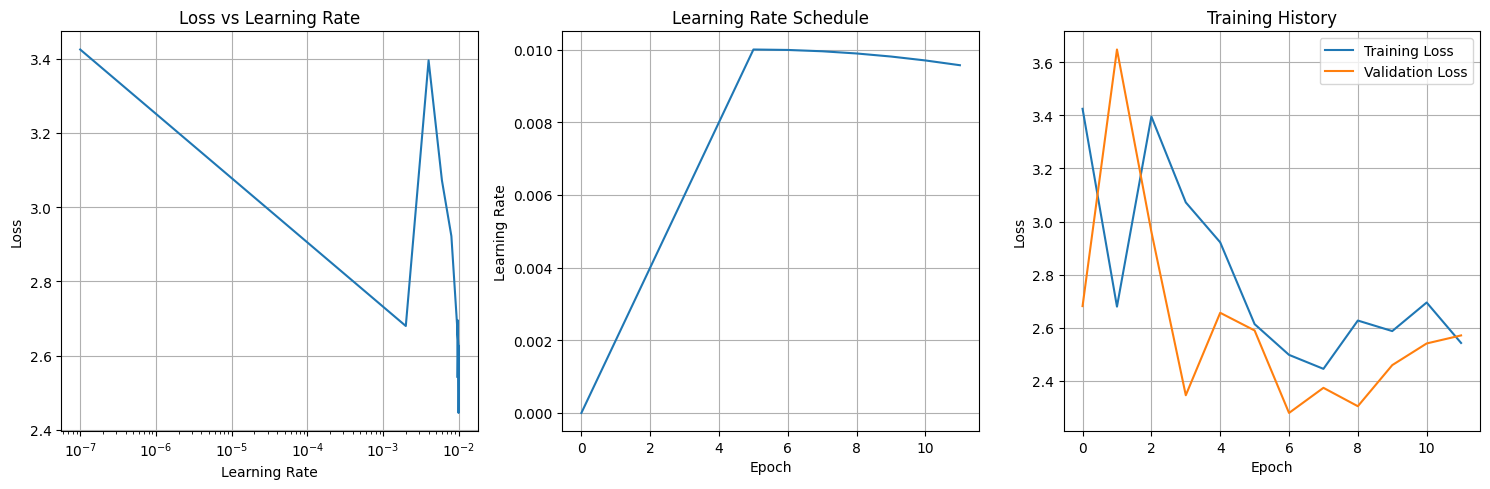

In [149]:
def main():
    pdf_dir = "Perkategori/"
    model, history, learning_rates = train_model(pdf_dir)
    return model, history, learning_rates

if __name__ == "__main__":
    model, history, learning_rates = main()

### Train Data

In [154]:
def train_model(pdf_dir):
    # Load data
    input_data, output_data = load_and_preprocess_pdf_data(pdf_dir)
    
    # Split data
    train_idx, val_idx = train_test_split(
        np.arange(input_data['text_input'].shape[0]), 
        test_size=0.2, 
        random_state=42
    )
    
    # Prepare training and validation sets
    X_train_text = input_data['text_input'][train_idx]
    X_train_explanation = input_data['explanation_input'][train_idx]
    y_train = {
        'understanding': output_data['understanding'][train_idx],
        'completeness': output_data['completeness'][train_idx]
    }
    
    X_val_text = input_data['text_input'][val_idx]
    X_val_explanation = input_data['explanation_input'][val_idx]
    y_val = {
        'understanding': output_data['understanding'][val_idx],
        'completeness': output_data['completeness'][val_idx]
    }
    
    # Initialize model
    model = FeynMindModelV2(dropout_rate=0.4, l2_regularization=1e-4)
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss={
            'understanding': 'categorical_crossentropy',
            'completeness': 'categorical_crossentropy'
        },
        metrics={
            'understanding': ['accuracy'],
            'completeness': ['accuracy']
        }
    )
    
    # Train model
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    
    history = model.fit(
        x=[X_train_text, X_train_explanation],
        y=y_train,
        validation_data=([X_val_text, X_val_explanation], y_val),
        epochs=50,
        batch_size=16,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )
    
    # Modify prediction and evaluation steps
    predictions = model.predict([X_val_text, X_val_explanation])
    
    # Convert predictions to class labels
    understanding_pred = np.argmax(predictions[0], axis=1)
    completeness_pred = np.argmax(predictions[1], axis=1)
    
    # Convert true labels to class indices
    understanding_true = np.argmax(y_val['understanding'], axis=1)
    completeness_true = np.argmax(y_val['completeness'], axis=1)
    
    # Print classification reports
    print("\nUnderstanding Classification Report:")
    print(classification_report(understanding_true, understanding_pred))
    print("\nCompleteness Classification Report:")
    print(classification_report(completeness_true, completeness_pred))
    
    
    # Visualize training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(history.history['understanding_accuracy'], label='Training')
    plt.plot(history.history['val_understanding_accuracy'], label='Validation')
    plt.title('Understanding Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(history.history['completeness_accuracy'], label='Training')
    plt.plot(history.history['val_completeness_accuracy'], label='Validation')
    plt.title('Completeness Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, history

In [155]:
# # Calculate class weights for balancing
# class_weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(np.argmax(y_train['understanding'], axis=1)),
#     y=np.argmax(y_train['understanding'], axis=1)
# )
# class_weights = {i: w for i, w in enumerate(class_weights)}

# # Create data pipelines with augmentation and class balancing
# train_data = create_data_pipeline(X_train, y_train, batch_size=16, augment=True, num_augmented=1)
# val_data = create_data_pipeline(X_val, y_val, batch_size=16)

In [156]:
def main():
    # Specify the directory containing PDFs
    pdf_dir = "Perkategori/"  # Update this to your PDF directory
    
    # Train the model
    model, history = train_model(pdf_dir)
    
    return model, history

Successfully processed 37 documents
Epoch 1/50


c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'explanation_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - completeness_accuracy: 0.2026 - completeness_loss: 2.6669 - loss: 4.6200 - understanding_accuracy: 0.3089 - understanding_loss: 1.9323 - val_completeness_accuracy: 0.2500 - val_completeness_loss: 1.3871 - val_loss: 4.8477 - val_understanding_accuracy: 0.3750 - val_understanding_loss: 3.3248 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - completeness_accuracy: 0.3570 - completeness_loss: 1.4694 - loss: 3.5388 - understanding_accuracy: 0.3527 - understanding_loss: 1.8844 - val_completeness_accuracy: 0.3750 - val_completeness_loss: 1.9285 - val_loss: 3.2589 - val_understanding_accuracy: 0.2500 - val_understanding_loss: 1.1847 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - completeness_accuracy: 0.3089 - completeness_loss: 1.5385 - loss: 2.8910 - understanding_accuracy: 0.2213 - understanding_loss: 1.1991 - val_completeness_accuracy: 0.2500 - val_completeness_loss: 1.4502 - val_loss: 2.7571 - v

c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (8, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step

Understanding Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.38      1.00      0.55         3
           2       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.12      0.33      0.18         8
weighted avg       0.14      0.38      0.20         8


Completeness Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.38      1.00      0.55         3
           2       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.12      0.33      0.18         8
weighted avg       0.14      0.38      0.20         8



c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Salsa\PycharmProjects\pytorch\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

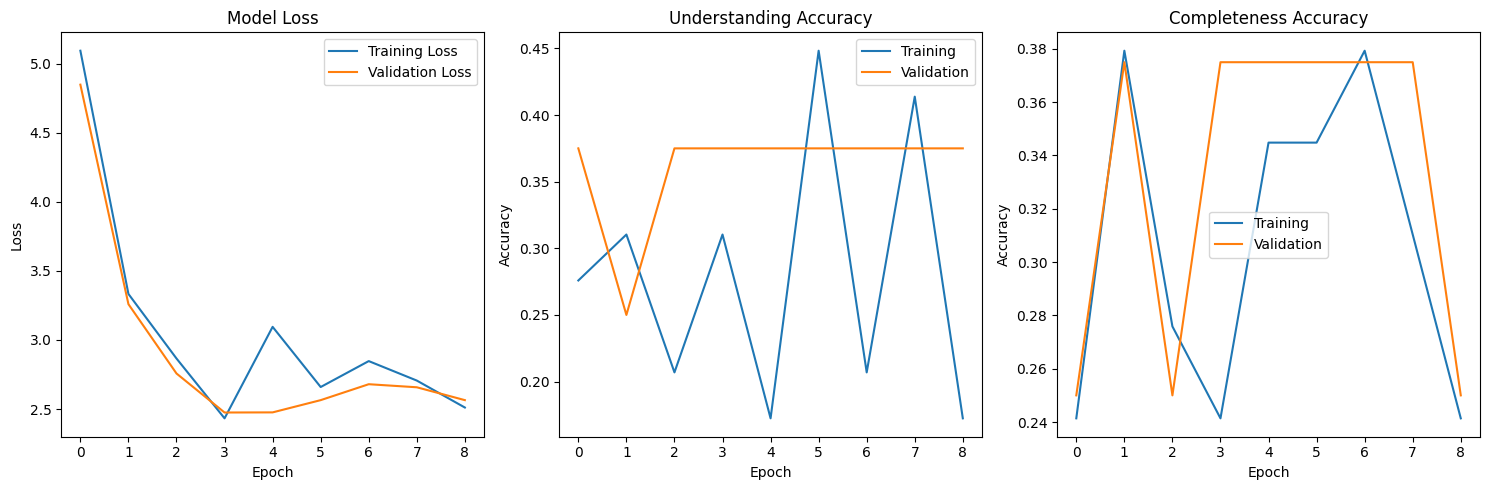

In [157]:
if __name__ == "__main__":
    model, history = main()